## Download dataset

In [1]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz

import tarfile

def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=output_path)

extract_tar_gz('xray_dataset.tar.gz', '.')

--2023-07-27 17:49:53--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.216.102.3, 52.216.41.73, 52.217.235.217, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.216.102.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223407715 (1.1G) [application/x-gzip]
Saving to: ‘xray_dataset.tar.gz’

xray_dataset.tar.gz 100%[===================>]   1.14G  42.6MB/s    in 27s     

2023-07-27 17:50:20 (43.6 MB/s) - ‘xray_dataset.tar.gz’ saved [1223407715/1223407715]



## 1. Introduction

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Input, applications, initializers
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
img_size = 256

train_set = tf.keras.utils.image_dataset_from_directory(
    directory='chest_xray/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size),
    validation_split=0.20,
    subset="training",
    seed=417)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory='chest_xray/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size),
    validation_split=0.20,
    subset="validation",
    seed=417)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory='chest_xray/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size))

normalization_layer = layers.Rescaling(1/255)

train_set_normalized = train_set.map(lambda x, y: (normalization_layer(x), y))
validation_set_normalized = validation_set.map(lambda x, y: (normalization_layer(x), y))
test_set_normalized = test_set.map(lambda x, y: (normalization_layer(x), y))

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


## 2. Data Exploration

In [4]:
train_set.class_names

['NORMAL', 'PNEUMONIA']

In [5]:
train_set_elem = train_set.take(1)
for images, labels in train_set_elem:
    images = images.numpy()
    labels = labels.numpy()

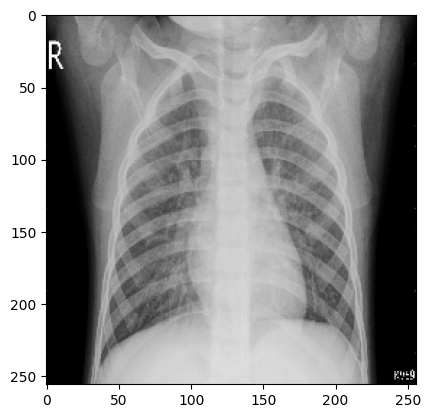

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


In [6]:
idx = 0
plt.imshow(images[idx]/255.0)
plt.show()
print(f"Training Set Image Label: {labels[idx]}")
print(f"Training Set Image Shape: {images[idx].shape}")

In [7]:
test_set_elem = test_set.take(1)
for images, labels in test_set_elem:
    images = images.numpy()

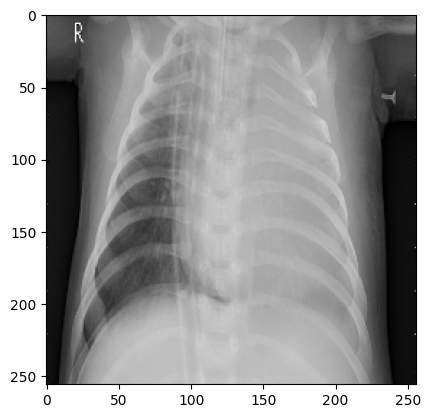

Test Set Image Label: [0. 1.]


In [8]:
idx = 16
plt.imshow(images[idx]/255.0)
plt.show()
print(f"Test Set Image Label: {labels[idx]}")

## 3. First Model: Simple CNN I

In [9]:
first_model = models.Sequential()

first_model.add(layers.Conv2D(filters=16, kernel_size=3, strides=2, activation='relu', input_shape=(img_size, img_size, 3)))
first_model.add(layers.MaxPooling2D(pool_size=3, strides=2))
first_model.add(layers.Flatten())

first_model.add(layers.Dense(16, activation='relu'))
first_model.add(layers.Dense(2))

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
first_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

first_model.summary()

first_model.fit(train_set_normalized, epochs=5, validation_data=validation_set_normalized)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 63504)             0         
                                                                 
 dense (Dense)               (None, 16)                1016080   
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1,016,562
Trainable params: 1,016,562
Non-trainable params: 0
______________________________________________

## 4. First Model: Simple CNN II

In [10]:
first_model = models.Sequential()

first_model.add(layers.RandomZoom(height_factor=0.1))
first_model.add(layers.RandomRotation(factor=0.2))

first_model.add(layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', input_shape=(img_size, img_size, 3)))
first_model.add(layers.MaxPooling2D(pool_size=3, strides=2))

first_model.add(layers.Conv2D(filters=256, kernel_size=3, strides=2, activation='relu'))
first_model.add(layers.MaxPooling2D(pool_size=3, strides=2))
first_model.add(layers.Flatten())

first_model.add(layers.Dense(256, activation='relu'))
first_model.add(layers.Dropout(0.5))

first_model.add(layers.Dense(64, activation='relu'))
first_model.add(layers.Dropout(0.5))

first_model.add(layers.Dense(32, activation='relu'))
first_model.add(layers.Dropout(0.5))

first_model.add(layers.Dense(2))

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
first_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
first_model.build((None, img_size, img_size, 3))

first_model.summary()
first_model.fit(train_set_normalized, epochs=15, validation_data=validation_set_normalized, callbacks=[early_stopping_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 128)     3584      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 256)     

## 5. Second Model: Transfer Learning

In [12]:
base_model = applications.resnet_v2.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)

base_model.trainable = False

input_layer = Input(shape=(img_size, img_size, 3))

preprocessed_input_layer = applications.resnet_v2.preprocess_input(input_layer)
preprocessed_input_layer = layers.RandomZoom(height_factor=0.1)(preprocessed_input_layer)
preprocessed_input_layer = layers.RandomRotation(factor=0.2)(preprocessed_input_layer)

features_layer = base_model(preprocessed_input_layer, training=False)

global_pooling = layers.GlobalAveragePooling2D()(features_layer)

fc1 = layers.Dense(512)(global_pooling)
fc1 = layers.ReLU()(fc1)

fc2 = layers.Dense(128)(fc1)
fc2 = layers.ReLU()(fc2)

fc3 = layers.Dense(32)(fc2)
fc3 = layers.ReLU()(fc3)

output = layers.Dense(2)(fc3)

second_model = Model(inputs=input_layer, outputs=output)

second_model.summary()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
second_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

second_model.fit(train_set, epochs=10, validation_data=validation_set, callbacks=[early_stopping_callback])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 random_zoom_2 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                           

In [13]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable=False

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
second_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

second_model.fit(train_set, epochs=5, validation_data=validation_set, callbacks=[early_stopping_callback])

Epoch 1/5
33/33 [==============================] - 55s 1s/step - loss: 0.1361 - accuracy: 0.9460 - val_loss: 0.2126 - val_accuracy: 0.9187
Epoch 2/5
33/33 [==============================] - 42s 1s/step - loss: 0.0906 - accuracy: 0.9656 - val_loss: 0.1285 - val_accuracy: 0.9532
Epoch 3/5
33/33 [==============================] - 41s 1s/step - loss: 0.0850 - accuracy: 0.9673 - val_loss: 0.1778 - val_accuracy: 0.9302
Epoch 4/5
33/33 [==============================] - 42s 1s/step - loss: 0.0745 - accuracy: 0.9709 - val_loss: 0.1571 - val_accuracy: 0.9407


## 6. Evaluating on the Test Set

In [14]:
first_model_test_loss, first_model_test_acc = first_model.evaluate(test_set_normalized)

print(f"Test set accuracy of first model: {first_model_test_acc}")

second_model_test_loss, second_model_test_acc = second_model.evaluate(test_set)

print(f"Test set accuracy of second model: {second_model_test_acc}")


5/5 [==============================] - 5s 275ms/step - loss: 0.4144 - accuracy: 0.8446
Test set accuracy of first model: 0.8445512652397156
5/5 [==============================] - 9s 2s/step - loss: 0.3623 - accuracy: 0.8654
Test set accuracy of second model: 0.8653846383094788
